# What's Cooking? A Kaggle Challenge

### Overview:  
"What's Cooking?" is a Kaggle Challenge where one attempts to predict the cuisine of a food based on its ingredients. I developed my code locally, tested which models worked best, and tuned the final model to get the best results possible.

### Approach:

Working with unstructured text data  ironically provides a lot of structure in terms of model approach. The industry consensus is to start with is a Support Vector Machine, more specifically a Support Vector Classifier. This is because SVC's are much less likely to overfit thanks to the inherent regularization (and hyperparmater tuning). One big caveat is that SVC's are computationally expensive and don't offer parallelization speedups. To prep the data for input, words (in this case ingredients) need to be enocoded as numbers. This translates to high dimensional data, which can prohibit the use of SVC's. Should this prove to be the case, we can use a dimenion reducing algorithm such as Singluar Value Decompisition (SVD). PCA will not be an option as it does not work with sparse datasets. Models to be benchmarked include... 
- Support Vector Classifiers
- Random Forest
- Logistic Regression
- K-Nearest Neighbors
- Multinomial Naive Bayes
- Sequential Neural Netowrk

Evaluation will be scikit-learn's accuracy metric, as it most accurately represents what Kaggle will be using to judge submitted models. Unfortunately we are working with significantly imbalanced data, so stratification of our sampling, down-sampling, and over-sampling will be tested for accuracy gains. 

Note: The machine learning models were tuned using GridSearchCV, an example of which is provided for the first SVC model. The rest were not included to keep the notebook more concise. 

### Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict
from operator import itemgetter  
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import timeit
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
%matplotlib inline

### Read in Kaggle Files

In [2]:
#Reading in the provided JSON files
train_file = json.load(open('C:/Users/mikes/Documents/Kaggle/What\'s Cooking/train.json'))
sub_file = json.load(open('C:/Users/mikes/Documents/Kaggle/What\'s Cooking//test.json'))

### Prep Test and Train

In [3]:
def join_ingredients(file):
    """Helper function to turn ingredients into a list for each food."""
    ingredients_list = [" ".join(line['ingredients']) for line in file]
    return(ingredients_list)

In [4]:
#Prepping the training data
ingredients_list = join_ingredients(train_file)
cuisine_list = [line['cuisine'] for line in train_file]

#Creating the training dataframe
train = pd.DataFrame(data = np.column_stack([ingredients_list, cuisine_list]),
            columns = ['Ingredients', 'Cuisine'])

#Prepping the submission data
ingredients_list = join_ingredients(sub_file)
id_list = [line['id'] for line in sub_file]

#Creating the submission dataframe
sub = pd.DataFrame(data = np.column_stack([ingredients_list, id_list]),
                    columns = ['Ingredients', 'id'])

### Feature Engineering

In order for our text data to be usable in machine learning models, we need to convert the input to numbers. This can be done using scikit-learn's "Text-Frequency Inverse Document Frequency" library. Common words like 'and' and 'or' are removed as they provide minimal information.

In [5]:
#Setting the tfidf 
tfidf = TfidfVectorizer(binary=True, stop_words='english')

#Fitting and transforming the ingredient input with tfidf
X = tfidf.fit_transform(train['Ingredients']).astype('float')
X_submission = tfidf.transform(sub['Ingredients']).astype('float')

#Creating a dataframe of words and their tfidf grades
tfidf_values = dict(zip(tfidf.get_feature_names(), X.sum(axis=0).tolist()[0]))
tfidf_grades = pd.DataFrame(list(tfidf_values.items()), columns = ['Ingredient', 'Count'])

### Encode the Output

In [43]:
#Encoding the 'Cusine' data
lb = LabelEncoder()
y = lb.fit_transform(train['Cuisine'])

#Mapping the encoded labels for use in a confusion matrix
label_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
cm_labels = label_mapping.keys()

### Split Train And Test

In order to compare mutltiple models, we need to be able to assess their prediction accuracy. This is done by splitting the provided training data into 'Train' and 'Test'. This allows one to verify the model generalizes well onto unseen data. 

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### Benchmark Helper Function

In [45]:
def benchmark(model, Xtrain, Xtest, ytrain, ytest):
    """Helper function to benchmark model accuracy"""
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    return(100* np.round(accuracy_score(ytest, y_pred), 4))

### Benchmark Dataframe

Here we create the dataframe that will store the accuracy and run-time of each model.

In [46]:
model_names = ['Support_Vector_Classifier', 'OVR_SVC', 'Random_Forest', 'Logistic_Regression', \
               'K-Nearest_Neighbors', 'Multinomial_Naive_Bayes', 'Sequential_NN']
benchDF = pd.DataFrame(0, columns = ['Accuracy %', 'Run_Time (s)'], index = model_names)

# Exploratory Plots

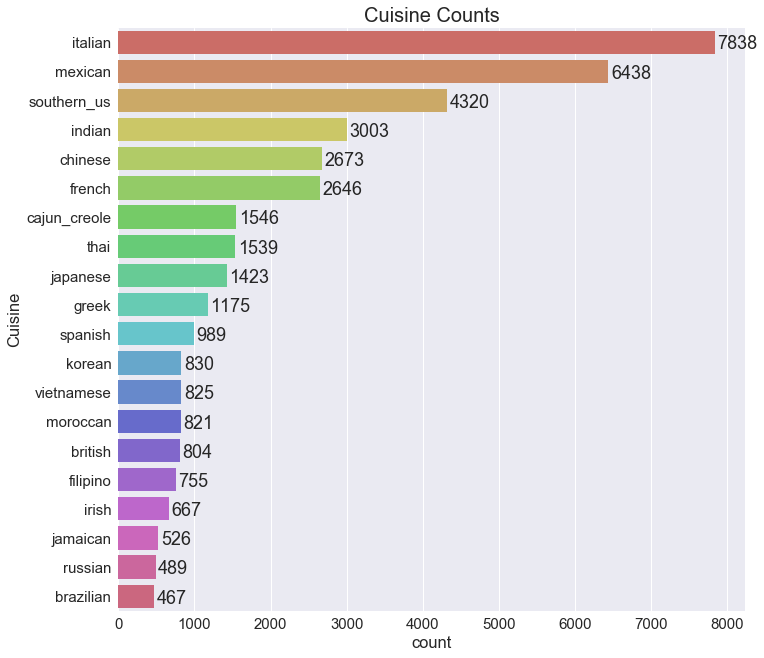

In [47]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
ax = sns.countplot(y = train.Cuisine, palette='hls', order = train.Cuisine.value_counts().index)#, edgecolor='k', linewidth=1)
plt.gcf().set_size_inches(10, 10)
plt.title('Cuisine Counts', size=20)
for p, label in zip(ax.patches, train['Cuisine'].value_counts()):
    ax.annotate(label, (p.get_width()+35, p.get_y()+.63))

Easy to see that we are dealing with a pretty imbalanced data set. (ex: 'italian' shows up over 16 times more than 'brazilian' does)

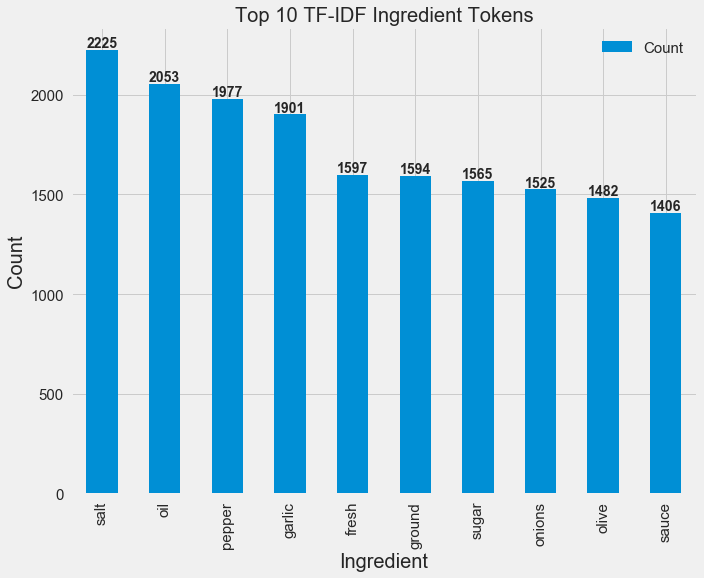

In [48]:
plt.style.use('fivethirtyeight')
top10_ingreds = tfidf_grades.sort_values('Count', ascending=False)[:10]
top10_ingreds.set_index(['Ingredient'], inplace=True)
ax = top10_ingreds.sort_values('Count',ascending=False).plot(kind='bar', figsize=(10, 8))
plt.title('Top 10 TF-IDF Ingredient Tokens')
plt.xlabel('Ingredient', size=20)
plt.ylabel('Count', size=20)
for p, label in zip(ax.patches, top10_ingreds['Count']):
    ax.annotate(int(label), (p.get_x(), p.get_height()+13), size=14, weight='bold');

Right away we can see that 'salt' has the highest tfidf value in the dataset. Here we can see the impact of our tokenizer, separating by word and not necessarily by ingredient. 'fresh' is not something you can put in a food, and thus must be part of at least a bigram. This means some features will be correlated, an example being "fresh ground pepper".

### Network Diagram For Top 20 Ingredient Words for French and Italian

In [49]:
def topNumGrams(cuisine, num_grams):
    df = train[train['Cuisine'] == cuisine]
    vec = CountVectorizer(analyzer='word', stop_words='english')
    counts = vec.fit_transform(df['Ingredients'])
    dfCounts = dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
    df = pd.DataFrame(list(dfCounts.items()), columns=['Ingredients', 'Counts'])
    df.set_index('Ingredients', inplace=True)
    top_df = df.sort_values('Counts', ascending=False)[:num_grams]
    top_df['Cuisine'] = cuisine.upper()
    return(top_df)

In [50]:
french = topNumGrams('french', 20).reset_index(level=0)
italian = topNumGrams('italian', 20).reset_index(level=0)
joint_df = pd.concat([french, italian])

In [51]:
#Building the node and edge framework from the pandas dataframe
g = nx.from_pandas_edgelist(joint_df, source='Cuisine', target='Ingredients')

In [52]:
#Default color is red
joint_df['Color'] = 'r'
#If the cuisine is French, switch the color to blue
joint_df.loc[joint_df['Cuisine'] == 'FRENCH', 'Color'] = 'yellow'
#Finding ingredient in both french and italian cuisines
dups = joint_df[joint_df.duplicated('Ingredients')]['Ingredients'].values
#Changing ingredients in both cuisines to be green
joint_df.loc[joint_df['Ingredients'].isin(dups), 'Color'] = 'cyan'
colorsdf = joint_df.drop_duplicates('Ingredients')

In [53]:
#Mapping the color for each node by ingredient
colors = []
for i in g.nodes():
    if i == 'FRENCH':
        colors.append('yellow')
    elif i == 'ITALIAN':
        colors.append('r')
    else:
        colors.append(joint_df[joint_df['Ingredients'] == i]['Color'].values[0])

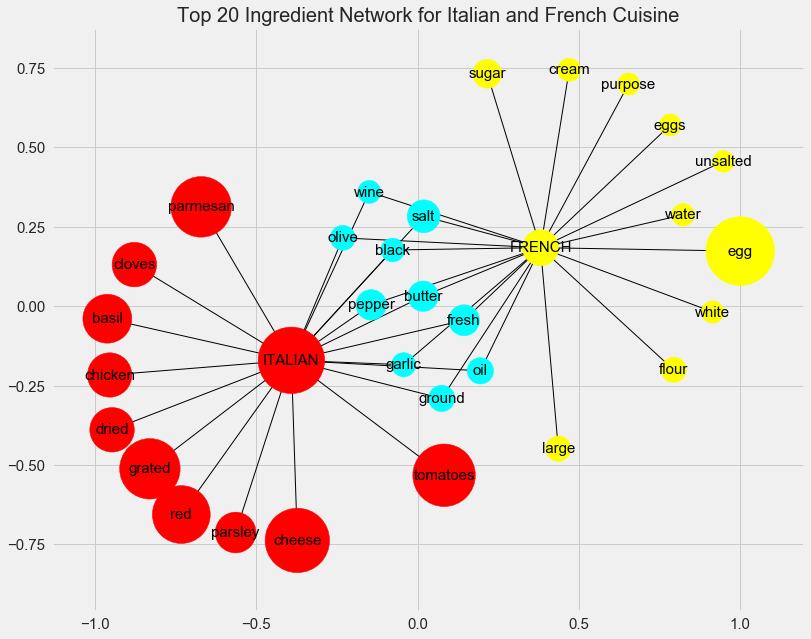

In [54]:
location = nx.spring_layout(g, k= 0.35)
nx.draw_networkx(g, location, node_size=joint_df['Counts']*.8, node_color=colors, font_size=15)
plt.title('Top 20 Ingredient Network for Italian and French Cuisine', size=20)
plt.gcf().set_size_inches(12, 10)

You can see that these two cuisines have a lot of ingredients in common, and thus it is reasonable to expect there will be some misclassification between the two.

# 1) Support Vector Machines

The first cell an example of how GridSearchCV was conducted for each model.

In [ ]:
#Creating the grid of parameters
#param_grid = {'C': [10, 25, 50],
#             'gamma': [.01, .1, 1 ],
#             'kernel': ['rbf']}
#svc = SVC()
#clf = GridSearchCV(svc, param_grid, cv = 3)
#clf.fit(X_train, y_train)
#y_pred = clf.best_estimator_.predict(X_test)
#clf.best_params_

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiating the model
svc = SVC(C=100, gamma=1, kernel='rbf')

benchDF.loc['Support_Vector_Classifier', 'Accuracy %'] = benchmark(svc, X_train, X_test, y_train, y_test)
benchDF.loc['Support_Vector_Classifier', 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiating the OVR classifier
ovr = OneVsRestClassifier(svc)

#Benchmark
benchDF.loc['OVR_SVC', 'Accuracy %'] = benchmark(ovr, X_train, X_test, y_train, y_test)
benchDF.loc['OVR_SVC', 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

# 2) Random Forest

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiate the RF model
rf = RandomForestClassifier(max_depth=50, 
                            max_features='sqrt', 
                            n_estimators=1600, n_jobs = -1)
#Benchmark
benchDF.loc['Random_Forest', 'Accuracy %'] = benchmark(rf, X_train, X_test, y_train, y_test)
benchDF.loc['Random_Forest', 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

# 3) Logisitic Regression

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiating the Model
lr = LogisticRegression(C=4, penalty='l2')

#Benchmark
benchDF.loc['Logistic_Regression', 'Accuracy %'] = benchmark(lr, X_train, X_test, y_train, y_test)
benchDF.loc['Logistic_Regression', 'Run_Time (s)']  = np.round(timeit.default_timer() - start_time, 2)

# 4) K-Nearest Neighbors 

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiate Model
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

#Benchmark
benchDF.loc['K-Nearest_Neighbors', 'Accuracy %'] = benchmark(knn, X_train, X_test, y_train, y_test)
benchDF.loc['K-Nearest_Neighbors', 'Run_Time (s)']  = np.round(timeit.default_timer() - start_time, 2)

# 5) Multinomial Naive Bayes

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiate Model
nb = MultinomialNB()

#Benchmark
benchDF.loc['Multinomial_Naive_Bayes', 'Accuracy %'] = benchmark(nb, X_train, X_test, y_train, y_test)
benchDF.loc['Multinomial_Naive_Bayes', 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

# 6) Sequential Neural Network 

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [ ]:
#Convert integers to dummy variables
dummy_y = pd.get_dummies(y_train)

In [ ]:
def model_struct():
    #create model
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(20, activation='softmax'))
    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
    return model

In [ ]:
#Starting Timer
start_time = timeit.default_timer()

model = model_struct()
model.fit(X_train, dummy_y, epochs=35, batch_size=128, verbose=0)

y_pred = model.predict(X_test)
y_pred_clean = pd.DataFrame(y_pred).idxmax(axis=1).values
benchDF.loc['Sequential_NN', 'Accuracy %'] = 100*np.round(accuracy_score(y_test, y_pred_clean), 4)
benchDF.loc['Sequential_NN', 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

### Results

In [ ]:
benchDF

As suspected, the strongest performers are the Support Vector Classifiers, with the OneVsRest SVC providing the greatest accuracy. Let's view what the OVR_SVC predicted via a confusion matrix.

### Confusion Matrix

In [ ]:
#Creating the Confusion Matrix
#y_pred = ovr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(data=cm, index=[i for i in cm_labels], columns=[i for i in cm_labels])
normalized_cm_df = cm_df/cm_df.sum(axis=1)
normalized_cm_df = np.round(normalized_cm_df, 2)
plt.figure(figsize=(12, 12))
sns.heatmap(normalized_cm_df, cmap='Blues', annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

Here we can see that the 5 most frequent cuisines in the dataset (Indian, Italian, Mexican, Chinese, and Southern_US) are also the most accurately predicted. As we did not stratify our training data, it is not a suprise that the best model is biased towards selecting these options. 

### Ensemble Model

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('clf1', LogisticRegression(C=4, dual=False)),
                                    ('clf2', SVC(C=100, gamma=1, kernel='rbf', probability=True))], voting='soft', weights=[1, 2])
vclf.fit(X_train, y_train)
vclf.score(X_test, y_test)

The ensemble model of an SVC and Logistic Regression performed better than either alone, but still fell short of the OneVsRest model.

### Singluar Value Decomposition

In [ ]:
columns = ['Accuracy %', 'Run_Time (s)']
indexs = ['10_components', '100_components', '200_components', '300_components', '500_components', '800_components']
svdDF = pd.DataFrame(0, columns=columns, index=indexs)

In [ ]:
def svdBenchmark():
    for n_components in indexs:
        n = int(re.findall('\d+', n_components)[0])
        start_time = timeit.default_timer()
        
        #Specifying the number of sigma values we want
        svd = TruncatedSVD(n_components=n, n_iter=7, random_state=42)

        #Normalizing and pipelining
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)

        #Fitting/Transforming the input data
        X_lsa = lsa.fit_transform(X)

        #Splitting in to test and train
        X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, y, random_state = 0)

        #Fitting and Predicting with the SVC
        svc = SVC(C=10, gamma=1, kernel='rbf')
        svc.fit(X_train_lsa, y_train_lsa)
        #Checking the prediction accuracy
        y_pred = svc.predict(X_test_lsa)
        
        #Filling the SVD DF
        svdDF.loc[n_components, 'Accuracy %'] = 100*np.round(accuracy_score(y_test_lsa, y_pred), 2)
        svdDF.loc[n_components, 'Run_Time (s)'] = np.round(timeit.default_timer() - start_time, 2)

In [ ]:
svdBenchmark()
svdDF.loc['nonSVD_SVC', 'Accuracy %'] = np.round(benchDF.loc['Support_Vector_Classifier', 'Accuracy %'], 2)
svdDF.loc['nonSVD_SVC', 'Run_Time (s)'] = np.round(benchDF.loc['Support_Vector_Classifier', 'Run_Time (s)'], 2)
svdDF

SVD does not provide an advantage in either run-time or accuracy. At the reccomended setting of 100 significant components for Latent Semantic Analysis (LSA), the run time is about 125% of the original SVC, and sacrifices around 5% accuracy. Once the number of components reaches 800, we sacrfice ~0.23% accuracy while the run time increases by ~500%. SVD is not advantageous in this use case.

# Resampling to Increase Performance

Two ways of creating a balanced dataset from imbalanced data are over-sampling and down-sampling. The first involves resampling with replacement from the minority classes until they have the same number of observations as the majority class. Down-sampling involves removing samples from the majority classes until they have the same number of observations as the minority class. These methods will be benchmarked against the SVC model to see if they increase performance. 

### Down-sampling (Random Sampling)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_down, y_down = rus.fit_sample(X_train, y_train)

In [ ]:
svc = SVC(C=100, gamma=1, kernel='rbf')
svc.fit(X_down, y_down)
#Checking the prediction accuracy
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

### Down-sampling (Cluster Generation Based On Original Data)

This particular version of down-sampling creates a centroid cluster distribution of the majority classes with K-means. Data is then generated from the centroids to better preserve the structure of each majority class.

In [ ]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_down_clus, y_down_clus = cc.fit_sample(X_train, y_train)

In [ ]:
svc.fit(X_down_clus, y_down_clus)
#Checking the prediction accuracy
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

### Over-sampling (Random selection with replacement)

In [18]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_up, y_up = ros.fit_sample(X_train, y_train)

In [ ]:
svc.fit(X_up, y_up)
#Checking the prediction accuracy
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

It looks like there may be an advantage to over-sampling. Let's try and execute with OVR_SVC

In [42]:
#Starting Timer
start_time = timeit.default_timer()

#Instantiating the OVR classifier
ovr = OneVsRestClassifier(svc)

#Benchmark
print(benchmark(ovr, X_up, X_test, y_up, y_test))
print(np.round(timeit.default_timer() - start_time, 2))

82.02000000000001
-------------------------------------------------
24346.89


This is very time consuming to run, as we encounter the scaling problems that come with SVMs. While coming close to the performance of OVR_SVC, it does not increase accuracy and drastically increases run-time, and thus is not the best model.

# Conclusion

After thorough testing and evaluation, OneVsRest Support Vector Classification is the best model for this problem, providing prediction accuracy of ~82%. Opportunities for improvement include creating custom tokenization, and custom stemming for the  ingredient data. 